In [1]:
import pandas as pd
import re
import glob
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from datetime import datetime
import vtk
import pyvista as pv

In [2]:
def parse_info(file):
    global title, vars, coords
    coords = []
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('TITLE ='):
                title = line.split('=')[1].strip().strip('"')
            elif line.startswith('VARIABLES ='):
                vars = re.findall(r'"([^"]+)"', line)
            if line.startswith('#'):
                coords.append(int(float((line.split(' ')[8]))))

In [3]:
def extract_comp(file, comp):
    df = pd.read_csv(file, sep="  ", header=None, engine='python', skiprows=5, names=vars)
    data = df[comp].tolist()

    return data

In [4]:
def plot_component(file, comp, setBoundy=False, boundy=0): #'comp' should be a string!
    global time, y
    df = pd.read_csv(file, sep="  ", header=None, engine='python', skiprows=5, names=vars)

    time = df['Time'].tolist()
    y = df[comp].tolist()

    vmax = max([abs(n) for n in y])

    plt.plot(time, y)
    plt.title(f'{comp} at {coords}')
    plt.xlabel('Time since  rupture (seconds)')
    plt.ylabel(f'{comp}')

    if setBoundy == True:
        bound = boundy
    else:
         bound = vmax + vmax/20
    plt.ylim(-bound, bound)

### Moment magnitude from seismic moment $M_0$ in units $dyn \cdot cm$

## $M_w = \frac{2}{3} (\log_{10}M_0 - 16.1)$

Kanamori (1997)

#### SeisSol writes seismic moment in $N \cdot m$.
#### $dyn \cdot cm = N \cdot m \cdot 1\mathrm{e}{-7}$

In [5]:
def Mw(M0):
    return round(2/3 * (np.log10(M0*1e7) - 16.1),2)

In [6]:
# return (y,x,z) coordinates of line on surface mesh for pyvista sampling
def surfline(arry,arrx=100e3,z=0.):
    a = [arry,-arrx,z]
    b = [arry,arrx,z]
    return a,b

In [7]:
dip = 60
prefix = f'{dip}dip_mus76'
name_format = f'{prefix}/{prefix}-receiver-*****-00000.dat'

file_list = glob.glob(name_format)
file_list.sort()
print(file_list)

parse_info(file_list[0])
print(title, vars, coords)

['60dip_mus76/60dip_mus76-receiver-00001-00000.dat', '60dip_mus76/60dip_mus76-receiver-00002-00000.dat', '60dip_mus76/60dip_mus76-receiver-00003-00000.dat', '60dip_mus76/60dip_mus76-receiver-00004-00000.dat', '60dip_mus76/60dip_mus76-receiver-00005-00000.dat', '60dip_mus76/60dip_mus76-receiver-00006-00000.dat', '60dip_mus76/60dip_mus76-receiver-00007-00000.dat', '60dip_mus76/60dip_mus76-receiver-00008-00000.dat', '60dip_mus76/60dip_mus76-receiver-00009-00000.dat', '60dip_mus76/60dip_mus76-receiver-00010-00000.dat', '60dip_mus76/60dip_mus76-receiver-00011-00000.dat', '60dip_mus76/60dip_mus76-receiver-00012-00000.dat', '60dip_mus76/60dip_mus76-receiver-00013-00000.dat', '60dip_mus76/60dip_mus76-receiver-00014-00000.dat', '60dip_mus76/60dip_mus76-receiver-00015-00000.dat', '60dip_mus76/60dip_mus76-receiver-00016-00000.dat', '60dip_mus76/60dip_mus76-receiver-00017-00000.dat', '60dip_mus76/60dip_mus76-receiver-00018-00000.dat', '60dip_mus76/60dip_mus76-receiver-00019-00000.dat', '60dip_mus7

Find magnitude from SeisSol energy output

In [8]:
energy_file = f'{prefix}/{prefix}-energy.csv'
edf = pd.read_csv(energy_file)
M0_df = edf[edf['variable'] == 'seismic_moment'][['time','measurement']]
M0_total = M0_df.iloc[-1][1]
print(f'seismic moment: {M0_total}')
m = Mw(M0_total)
print(f'moment magnitude: {m}')

seismic moment: 1.76504e+20
moment magnitude: 7.43


(0.0, 29.99999999999832)

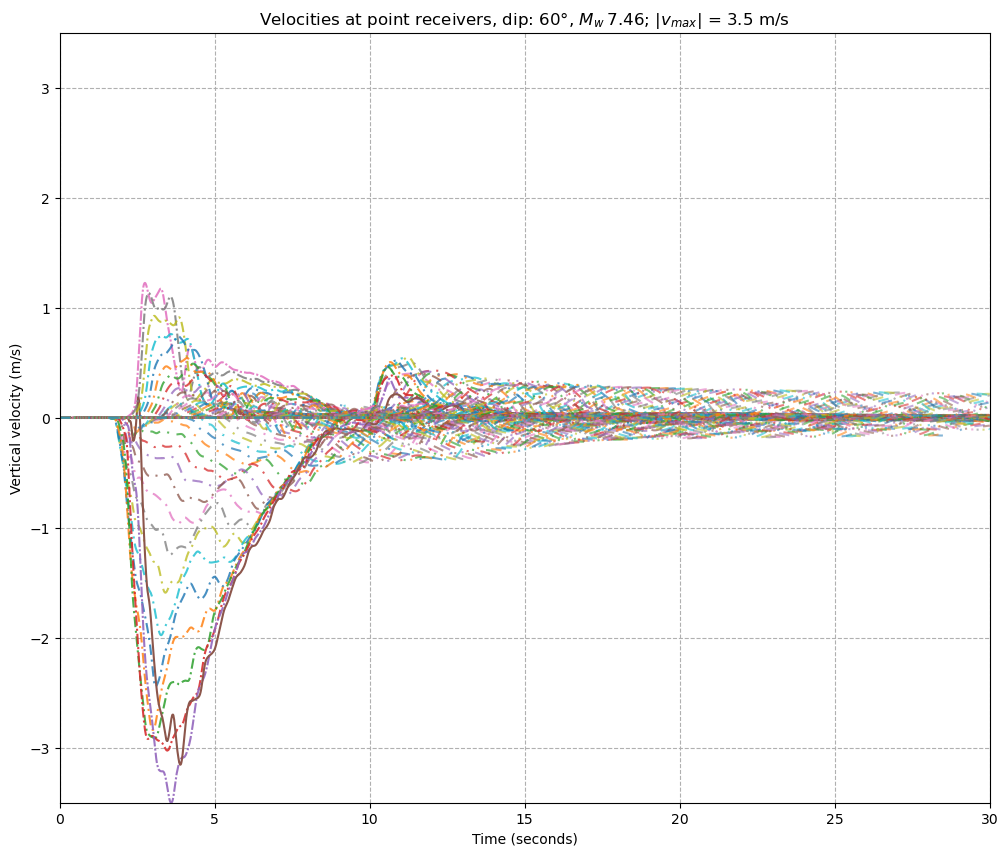

In [8]:
file_list = glob.glob(name_format)
file_list.sort()

time = extract_comp(file_list[0],"Time")

vmax = 0

fig, ax = plt.subplots(1,1, figsize=[12,10])

for i, file in enumerate(file_list):
    parse_info(file)
    y = extract_comp(file, 'v3')
    sep = (np.sqrt(abs(coords[1])/1000))
    alpha = 1/((sep/10)+1)
    ax.plot(time, y, linestyle=(0,(5, sep, 1, sep)), alpha=alpha)

    vmaxc = max([abs(n) for n in y])
    if vmaxc > vmax:
        vmax = vmaxc

ax.set_title(f"Velocities at point receivers, dip: {dip}°, $M_w\\:{m}$; |$v_{{max}}$| = {round(vmax,2)} m/s")

ax.set_ylabel("Vertical velocity (m/s)")
ax.set_xlabel("Time (seconds)")
ax.grid(True, linestyle='--')
ax.set_ylim(-3.5,3.5)
ax.set_xlim(0,max(time))

### Plot multi-array outputs (only works for identical node arrays)

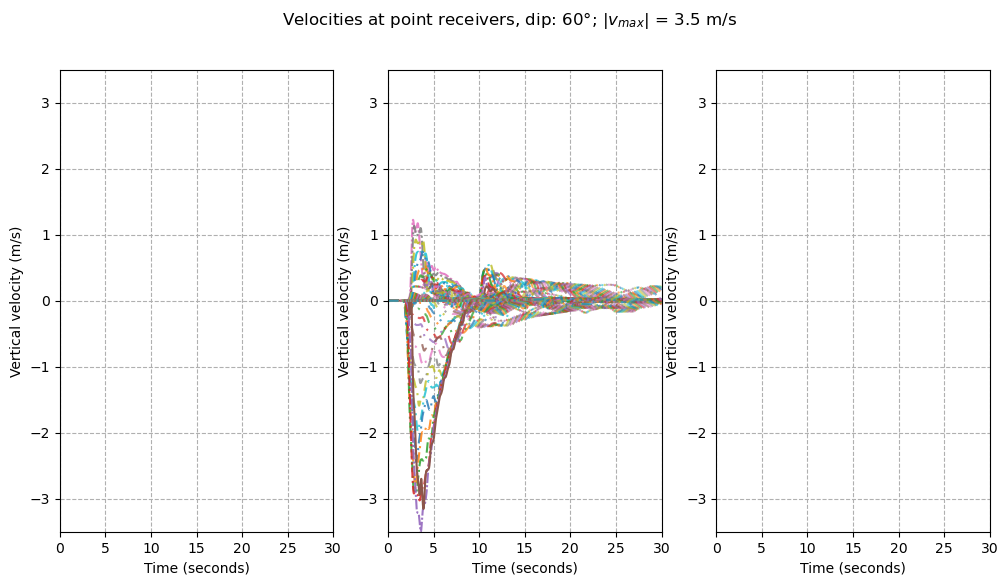

In [9]:
fig, ax = plt.subplots(1,3, figsize=[12,6])

for i, file in enumerate(file_list):
    # if i%2 == 0:
    #     continue
    parse_info(file)
    y = extract_comp(file, 'v3')
    ay = coords[0]
    sep = (np.sqrt(abs(coords[1])/1000))
    alpha = 1/((sep/10)+1)

    if ay == -5000:
        p = 0
    elif ay == 0:
        p = 1
    elif ay == 5000:
        p = 2

    ax[p].plot(time, y, label=f"{coords}", linestyle=(0,(5, sep, 1, sep)), alpha=alpha)

    vmaxc = max([abs(n) for n in y])
    if vmaxc > vmax:
        ax[p].set_title(f"Array at y={coords[i-1][0]}")
        vmax = vmaxc

fig.suptitle(f"Velocities at point receivers, dip: {dip}°; |$v_{{max}}$| = {round(vmax,2)} m/s")

# ax.legend(title="Receiver coordinates")
for i, axis in enumerate(ax):
    ax[i].set_ylabel("Vertical velocity (m/s)")
    ax[i].set_xlabel("Time (seconds)")
    ax[i].grid(True, linestyle='--')
    ax[i].set_ylim(-3.5,3.5)
    ax[i].set_xlim(0,max(time))

In [10]:
coordlist = []
ylist = []
# tlist = [] # to plot time, probably not needed
nlist = []
alist = []
plist = []

for i, file in enumerate(file_list):
    parse_info(file)
    y = extract_comp(file, 'v3')
    # t = extract_comp(file, "Time")
    coordlist.append(coords)
    ylist.append(abs(max(y)))

z = zip(coordlist,ylist)
zsort = sorted(z) # order all coordinates from (-x,-y,z) to (x,y,z)
l = list(zsort)
coordset, yset = zip(*l)
coordset = list(coordset)
yset = list(yset)

## SPLIT CELL HERE FOR QUICKER PLOTTING TIME

Text(0.5, 0.98, 'Peak vertical velocities per node; dip: 60°; |$v_{z,max}$| = 1.23 m/s')

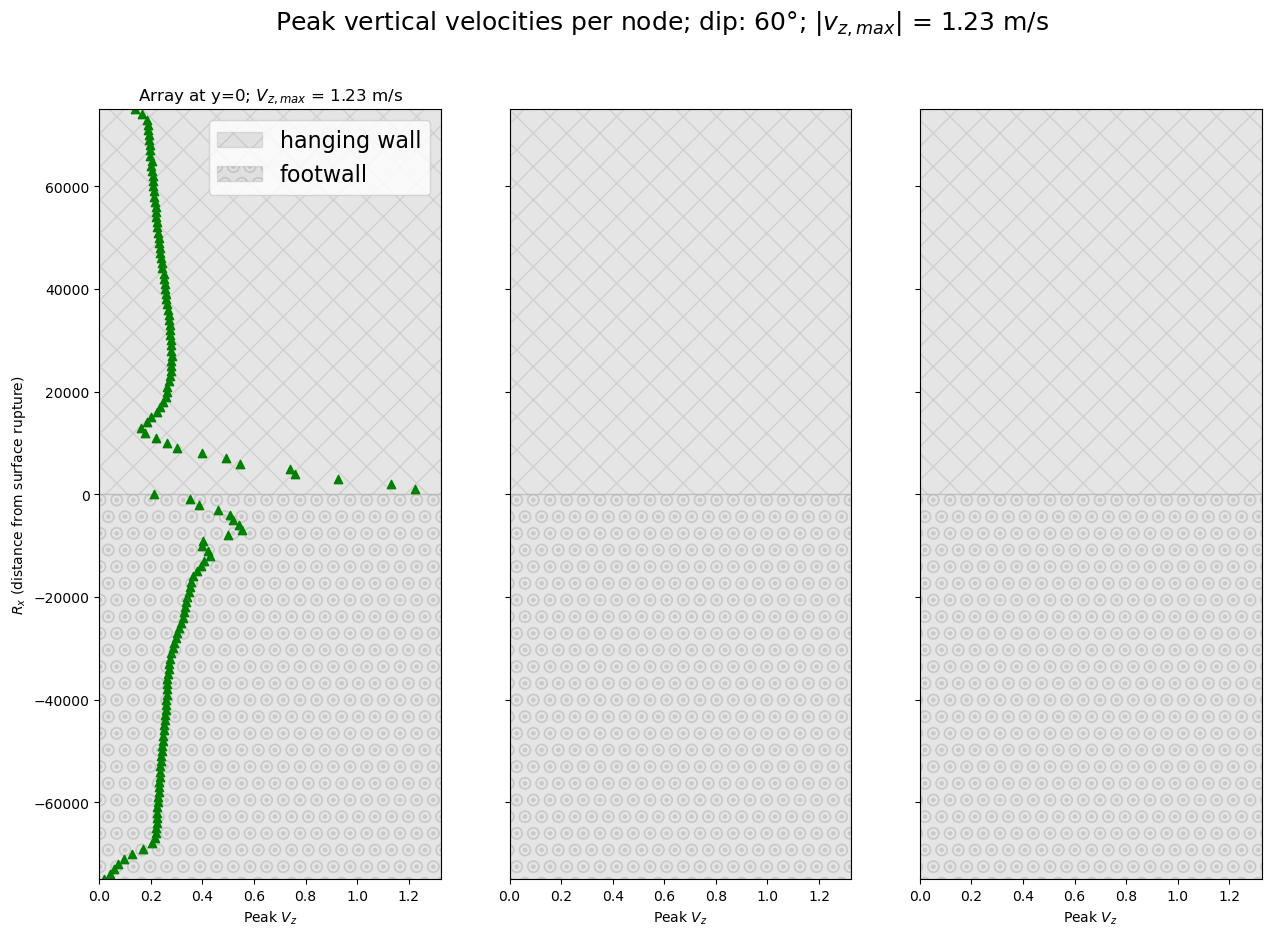

In [11]:
fig, ax = plt.subplots(1,3, figsize=[15,10], sharey=True)

p=-1
arrmaxlist = [0,0,0]

for i, c in enumerate(coordset):
    x = coordset[i][0]

    if x not in alist:
        alist.append(x)
        p += 1

    ax[p].scatter(yset[i],coordset[i][1], marker = '^', color="green")

    if yset[i] > arrmaxlist[p]:
        arrmaxlist[p] = yset[i]
    ax[p].set_title(f'Array at y={x}; $V_{{z, max}}$ = {round(arrmaxlist[p],2)} m/s')

    #print(f"I would plot ({yset[i]},{coordset[i][1]}) on {p}")
        
for plot in ax:
    plot.set_xlim(0,max(yset)+0.1)
    plot.set_ylim(coordset[0][1], coordset[-1][1])
    xmin, xmax = plot.get_xlim()
    plot.axhspan(0,coordset[-1][1],
                 color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
    plot.axhspan(coordset[0][1],0,
                 color='gray',alpha=0.2, hatch="O.", zorder=0, label='footwall')
    plot.set_xlabel(f'Peak $V_{{z}}$')
    
ax[0].set_ylabel("$R_{{x}}$ (distance from surface rupture)")
ax[0].legend(fontsize=16)
fig.suptitle(f'Peak vertical velocities per node; dip: {dip}°; |$v_{{z,max}}$| = {round(max(yset),2)} m/s', fontsize = 18)

ROTD50 function. Thank you Daniel

In [12]:
# given two orthogonal time series, compute rotated amplitudes
def rotated_amplitudes(y1, y2, n=180):
    # store amplitudes here
    thetaR=np.arange(0.0, np.pi, np.pi/n)
    amp = np.zeros(n)
    # cosine and sine of input angles
    cosR, sinR = np.cos(thetaR), np.sin(thetaR)
    # compute amplitude at each azimuth
    for i in range(n):
        yR = y1*cosR[i] + y2*sinR[i]
        amp[i] = np.max(np.abs(yR))
    # return results
    return amp
# now get RotD50
def compute_rotd50(y1, y2):
    amps = rotated_amplitudes(y1, y2, n=360)
    return np.median(amps)

In [13]:
rotds = []
xpeaks = []
ypeaks = []
zpeaks = []
peakvsums = []
ycoords = []

for file in file_list:
    parse_info(file)
    vx = extract_comp(file, 'v2')
    vy = extract_comp(file, 'v1')
    vz = extract_comp(file, 'v3')

    vxpeak = max([abs(u) for u in vx])
    vypeak = max([abs(v) for v in vy])
    vzpeak = max([abs(w) for w in vz])

    sums = []
    for i in range(len(vx)):
        compvecsum = np.sqrt(vx[i]**2 + vy[i]**2 + vz[i]**2)
        normsum = np.linalg.norm(compvecsum)
        sums.append(normsum)
    peakvsums.append(max(sums))

    xpeaks.append(vxpeak)
    ypeaks.append(vypeak)
    zpeaks.append(vzpeak)
    rotds.append(compute_rotd50(vxpeak,vypeak))
    ycoords.append(coords[1])

ycoords = -np.asarray(ycoords) #if Rx coordinates are reversed this fixes that

### Plot ROTD50

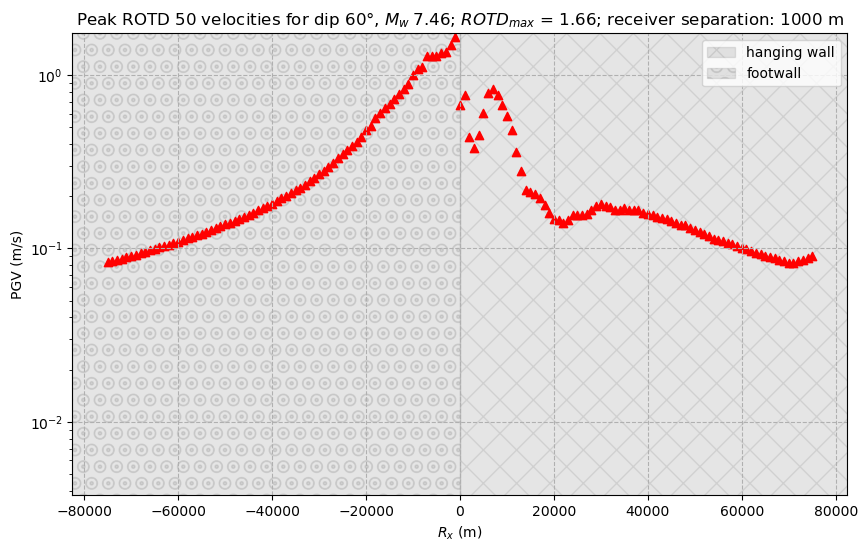

In [14]:
sep = abs(ycoords[1] - ycoords[0])

fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.grid(linestyle="--")
ax.scatter(ycoords,rotds, marker='^', color='red')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

ax.set(**{
    'xlabel': f'$R_{{x}}$ (m)',
    'ylabel': 'PGV (m/s)',
    'ylim': (ymin,ymax),
    'yscale': 'log',
    'title': f'Peak ROTD 50 velocities for dip {dip}°, $M_w\\:{m}$; $ROTD_{{max}}$ = {round(max(rotds),2)}; receiver separation: {sep} m'
})

ax.legend()
plt.show()

In [15]:
GMPEs = pd.read_csv('pygmm/AM_NS_7.44.txt')
print(GMPEs.head())

GMarr = GMPEs.to_numpy()
rxs = GMarr[:,1] * 1000 #convert to meters
ask = GMarr[:,2] / 100 #convert to m/s
cy = GMarr[:,3] / 100
bssa = GMarr[:,4] / 100
cb = GMarr[:,5] / 100

   Unnamed: 0   rxs       ask        cy      bssa        cb
0           0 -50.0  7.742820  6.566009  6.074696  7.286361
1           1 -49.0  7.860719  6.675235  6.194339  7.425341
2           2 -48.0  7.982776  6.789267  6.318380  7.569836
3           3 -47.0  8.109230  6.908428  6.447072  7.720183
4           4 -46.0  8.240333  7.033063  6.580688  7.876744


ROTD

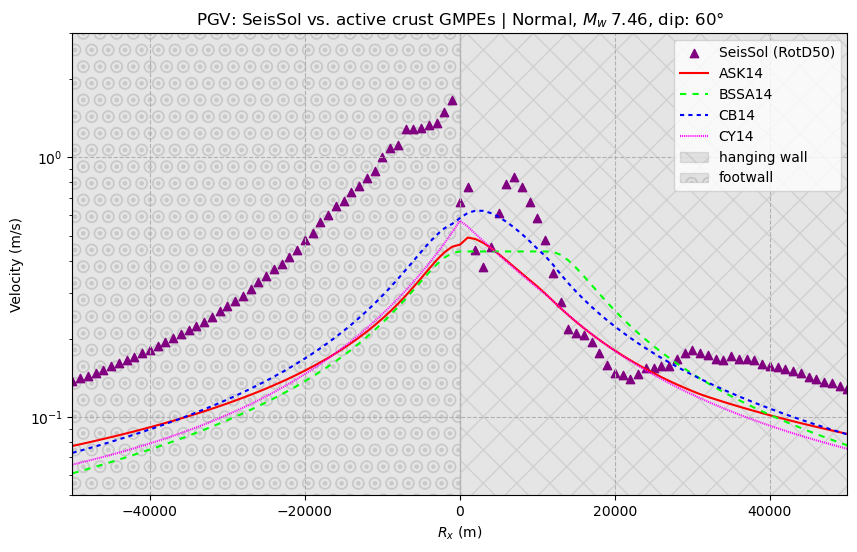

In [16]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.grid(linestyle="--")
ax.scatter(ycoords,rotds, marker='^', color='purple', label='SeisSol (RotD50)')
ax.plot(rxs,ask,color='red', label='ASK14')
ax.plot(rxs,bssa,color='xkcd:bright green', ls=(0,(3,3)),label='BSSA14')
ax.plot(rxs,cb,color='blue', ls=(0,(2,2)),label='CB14')
ax.plot(rxs,cy,color='magenta', ls=(0,(0.5,0.5)),label='CY14')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ymax=3
ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

ax.set(**{
    'xlabel': '$R_{{x}}$ (m)',
    'ylabel': 'Velocity (m/s)',
    'yscale': 'log',
    'ylim': (0.05,ymax),
    'xlim': (-50e3,50e3),
    'title': f'PGV: SeisSol vs. active crust GMPEs | Normal, $M_w\\:{m}$, dip: {dip}°',
})

ax.legend()
plt.show()

### Vx, Vy, Vz

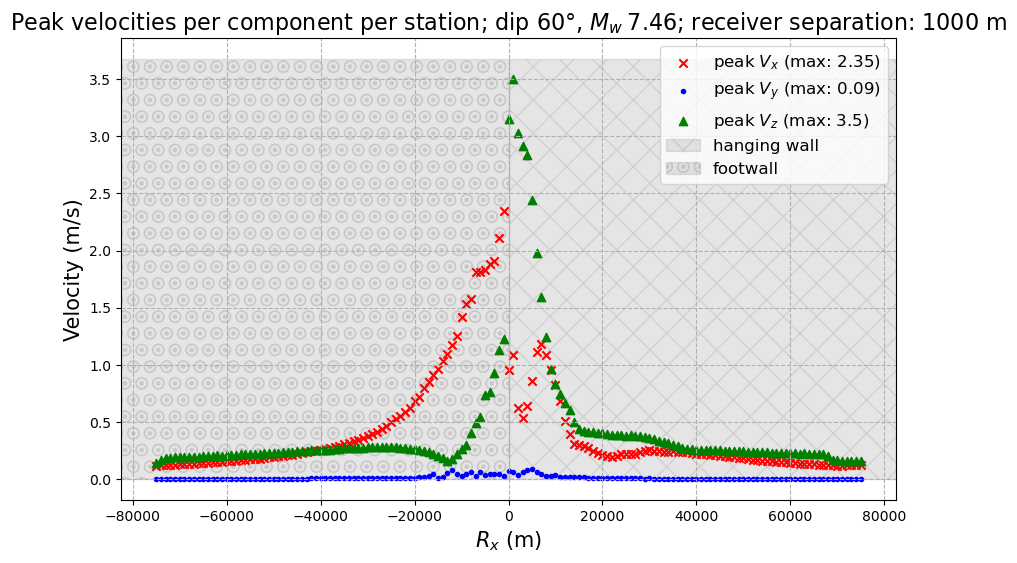

In [17]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.grid(linestyle="--")
ax.scatter(ycoords,xpeaks, color='red', marker='x', label=f'peak $V_{{x}}$ (max: {round(max(xpeaks),2)})')
ax.scatter(ycoords,ypeaks, color='blue', marker='.', label=f'peak $V_{{y}}$ (max: {round(max(ypeaks),2)})')
ax.scatter(ycoords,zpeaks, color='green', marker='^', label=f'peak $V_{{z}}$ (max: {round(max(zpeaks),2)})')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

ax.set_xlabel(f'$R_{{x}}$ (m)',fontsize=15)
ax.set_ylabel('Velocity (m/s)',fontsize=15)
ax.set_title(f'Peak velocities per component per station; dip {dip}°, $M_w\\:{m}$; receiver separation: {round(sep,2)} m',fontsize=16)
ax.legend(fontsize=12)
plt.show()

## Vector sum plot

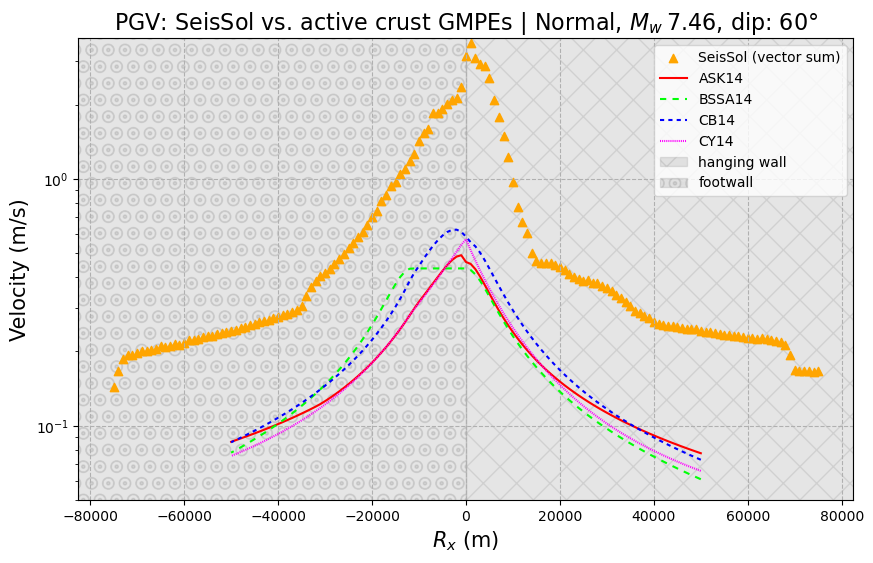

In [18]:
fig, ax = plt.subplots(1,1, figsize=[10,6])

ax.grid(linestyle="--")
ax.scatter(ycoords,peakvsums, marker='^', color='orange', label='SeisSol (vector sum)')
ax.plot(-rxs,ask,color='red', label='ASK14')
ax.plot(-rxs,bssa,color='xkcd:bright green', ls=(0,(3,3)),label='BSSA14')
ax.plot(-rxs,cb,color='blue', ls=(0,(2,2)),label='CB14')
ax.plot(-rxs,cy,color='magenta', ls=(0,(0.5,0.5)),label='CY14')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.axhspan(0,ymax,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
ax.axhspan(0,ymax,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

ax.set_xlabel(f'$R_{{x}}$ (m)',fontsize=15)
ax.set_ylabel('Velocity (m/s)',fontsize=15)
ax.set_yscale('log')
ax.set_ylim(5e-2,ymax)

# ax.set_xscale('log')
ax.legend()

ax.set_title(f'PGV: SeisSol vs. active crust GMPEs | Normal, $M_w\\:{m}$, dip: {dip}°',fontsize=16)
plt.show()

## Plot including standard deviations

In [19]:
stds = pd.read_csv('pygmm/AM_NS_7.44_stds.txt')

stdarr = stds.to_numpy()
rxs = stdarr[:,1] * -1000 #convert to meters and reverse to match my seissol coordinates
ask = stdarr[:,2] / 100 #convert to m/s
cy = stdarr[:,3] / 100
bssa = stdarr[:,4] / 100
cb = stdarr[:,5] / 100
ask_std = stdarr[:,6] #log-standard deviation
cy_std = stdarr[:,7]
bssa_std = stdarr[:,8]
cb_std = stdarr[:,9]

/var/folders/sn/vc1jwppj6ksd93y_fp9nbjvc0000gp/T/ipykernel_90784/3940252966.py:39: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(ycoords[-1],xmax)


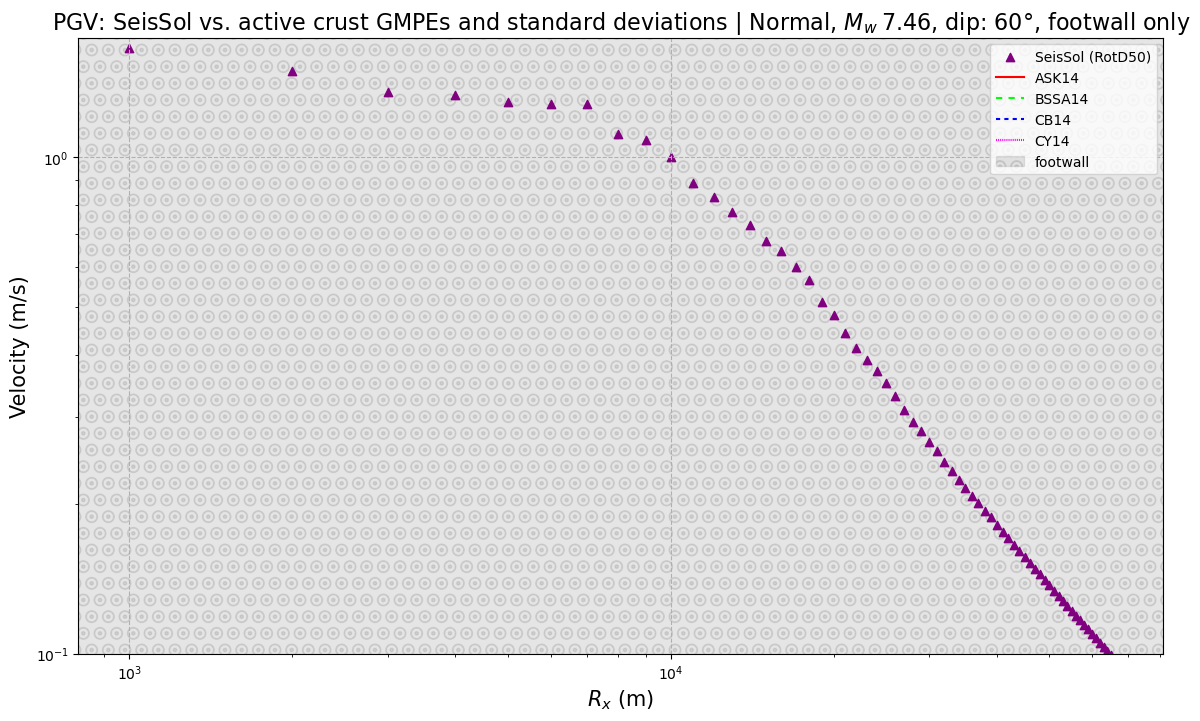

In [20]:
fig, ax = plt.subplots(1,1, figsize=[14,8])

fi = len(rxs) // 2 + 1 #index to only plot footwall PGVs
ri = len(ycoords)//2

ax.grid(linestyle="--")
ax.scatter(-ycoords[ri:],rotds[ri:], marker='^', color='purple', label='SeisSol (RotD50)')
ax.plot(-rxs[:fi],ask[:fi],color='red', label='ASK14')
ax.plot(-rxs[:fi],bssa[:fi],color='xkcd:bright green', ls=(0,(3,3)),label='BSSA14')
ax.plot(-rxs[:fi],cb[:fi],color='blue', ls=(0,(2,2)),label='CB14')
ax.plot(-rxs[:fi],cy[:fi],color='magenta', ls=(0,(0.5,0.5)),label='CY14')

ly1 = np.log(ask[:fi])-ask_std[:fi]
ly2 = np.log(ask[:fi])+ask_std[:fi]
ax.fill_between(x=-rxs[:fi],y1=np.exp(ly1),y2=np.exp(ly2),color="r",alpha=0.1,lw=2)

ly3 = np.log(bssa[:fi])-bssa_std[:fi]
ly4 = np.log(bssa[:fi])+bssa_std[:fi]
ax.fill_between(x=-rxs[:fi],y1=np.exp(ly3),y2=np.exp(ly4),color="xkcd:bright green",alpha=0.1,lw=2)

ly5 = np.log(cb[:fi])-cb_std[:fi]
ly6 = np.log(cb[:fi])+cb_std[:fi]
ax.fill_between(x=-rxs[:fi],y1=np.exp(ly5),y2=np.exp(ly6),color="blue",alpha=0.1,lw=2)

ly7 = np.log(cy[:fi])-cy_std[:fi]
ly8 = np.log(cy[:fi])+cy_std[:fi]
ax.fill_between(x=-rxs[:fi],y1=np.exp(ly7),y2=np.exp(ly8),color="magenta",alpha=0.1,lw=2)


ax.set_xlabel(f'$R_{{x}}$ (m)',fontsize=15)
ax.set_ylabel('Velocity (m/s)',fontsize=15)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_yscale('log')
ax.set_xscale('log')

ax.axhspan(0,ymax,xmin=0,xmax=1,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')
ax.set_ylim(0.1,ymax)
ax.set_xlim(ycoords[-1],xmax)

ax.legend()

ax.set_title(f'PGV: SeisSol vs. active crust GMPEs and standard deviations | Normal, $M_w\\:{m}$, dip: {dip}°, footwall only',fontsize=16)
plt.show()

In [21]:
def load_mesh(prefix,t):
    reader = vtk.vtkXdmfReader()
    reader.SetFileName(f'{prefix}/{prefix}-surface.xdmf')
    reader.Update()
    reader.UpdateTimeStep(t)
    return pv.wrap(reader.GetOutput())

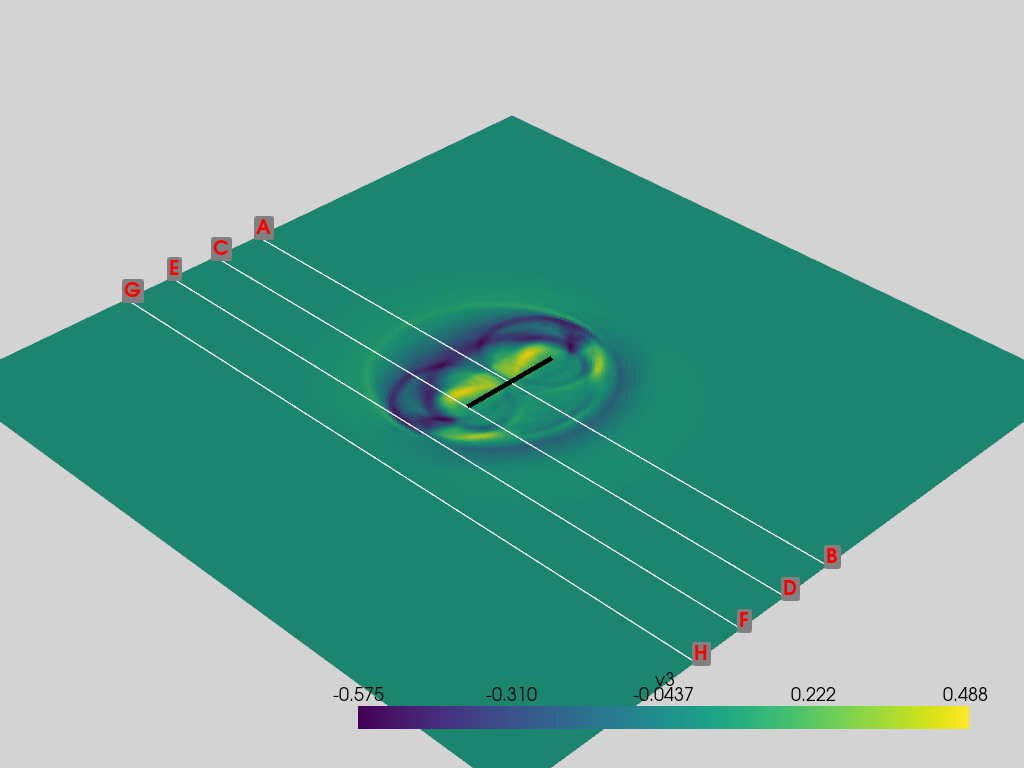

['locationFlag', 'partition', 'u1', 'u2', 'u3', 'v1', 'v2', 'v3', 'vtkValidPointMask', 'Texture Coordinates', 'Distance', 'vtkGhostType']


In [164]:
arrys = [0,15e3,30e3,45e3]
labels = [['A','B'],['C','D'],['E','F'],['G','H']]

fa = [-15e3,0,0]
fb = [15e3,0,0]

fault = pv.Line(fa,fb)
p = pv.Plotter(shape=(1,1),notebook=True)

tt = [10]

# t = 1

for t in tt:
    mesh = load_mesh(prefix,t)

    p.subplot(0,0)
    p.set_background('lightgrey')
    surf = p.add_mesh(mesh, scalars='v3')

    for i, arr in enumerate(arrys):
        a1, a2 = surfline(arr)
        line = pv.Line(a1,a2)
        p.add_mesh(line,color='w',line_width=2)
        p.add_point_labels(
            [a1,a2],[labels[i][0], labels[i][1]], font_size=20, point_color="red", text_color="red"
        )

    fault = p.add_mesh(fault, color='k', label='Fault',line_width=10)
    p.camera.zoom(1.5)
    
    p.show(jupyter_backend='panel')

    data = load_mesh(prefix,t).sample_over_line(a,b)

    print(data.point_data.keys())



In [117]:
fig, ax = plt.subplots(figsize=[10,5])

arry = 0
arrx = 100e3 #length of node array

a = [arry,-arrx,0] # (y,x,z) because of how they generate tutorial mesh
b = [arry,arrx,0]

x = data['Distance'] / 1000 - 100
vz = abs(data['v3']) * 100

ax.plot(x,vz)

ax.set(**{
    'yscale': 'log',
    'ylim': (1e-2,500),
    'ylabel': 'Velocity (cm/s)',
    'xlabel': '$R_x$ (km)',
    'title': f'$V_z$ at t = {t} s',
})
plt.show()

/var/folders/sn/vc1jwppj6ksd93y_fp9nbjvc0000gp/T/ipykernel_90784/83891292.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[10,5])


In [248]:
plotdict = {
    'yscale': 'linear',
    'ylim': (-200,200),
    'ylabel': 'Velocity (cm/s)',
    #'xlabel': '$R_x$ (km)',
}

## View animated plots in matplotlib window

In [210]:
%matplotlib osx
plt.close('all')

arrys = [0,15e3,30e3,45e3,60e3]
fig, axi = plt.subplots(len(arrys),1,figsize=[14,9],sharex=True)

comp = 'v2'

tt = np.arange(0,31,0.2)
for i, t in enumerate(tt):

    for j, ax in enumerate(axi):
        ax.clear()

        a, b = surfline(arrys[j])
        data = load_mesh(prefix,t).sample_over_line(a,b)
        
        x = data['Distance'] / 1000 - 100
        vz = data[comp] * 100

        ax.plot(x,vz)
        ax.set(**plotdict)
        ax.set_title(f'Array at y = {arrys[j]/1000} km')
        ax.grid(ls=':')

    fig.suptitle(f'{prefix}, component {comp} (dip {dip}°, $M_w$ {m}) | t = {round(t,2)} s',y=0.96)
    ax.set_xlabel('$R_x$ (km)')
    plt.pause(0.01)

plt.show()

## Save animation

In [ ]:
plt.close('all')

arrys = [0,15e3,30e3,45e3,60e3]
fig, axi = plt.subplots(len(arrys),1,figsize=[14,9],sharex=True)

comp = 'v2'

tt = np.arange(0,31,0.2)

def update(frame):
    t = tt[frame]
    for j, ax in enumerate(axi):
        ax.clear()

        a, b = surfline(arrys[j])
        data = load_mesh(prefix,t).sample_over_line(a,b)
        
        x = data['Distance'] / 1000 - 100
        vz = data[comp] * 100

        ax.plot(x,vz)
        ax.set(**plotdict)
        ax.set_title(f'Array at y = {arrys[j]/1000} km')
        ax.grid(ls=':')

    fig.suptitle(f'{prefix} component {comp} (dip {dip}°, $M_w$ {m}) | t = {round(t,2)} s',y=0.96)
    ax.set_xlabel('$R_x$ (km)')

    if frame%10 == 0:
        print(f"Rendering frame {frame + 1} of {len(tt)}", end="\r")


ani = FuncAnimation(fig, update, frames=len(tt), interval=50)

writer = FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
writetime = datetime.now().strftime("%y_%m_%d--%H-%M-%S")
ani.save(f'./Animations/{prefix}-{writetime}.mp4')

plt.close(fig)

## Get PGVs from mesh data

In [303]:
pgvplotdict = {
    'yscale': 'log',
    'ylabel': 'PGV (cm/s)',
    'ylim': [1,5e2]
}

In [323]:
plt.close('all')
# arrys = [0,15e3,30e3,45e3,60e3]
arrys = np.linspace(0,80e3,4)
fig, axi = plt.subplots(len(arrys),1,figsize=[14,9],sharex=True)

pgvs = [[] for _ in range(len(arrys))]

comp = 'v3'

#initialize pgv arrays with zeros based on individual line resolution
for ai, ar in enumerate(arrys):
    a, b = surfline(arrys[ai])
    data = load_mesh(prefix,t).sample_over_line(a,b)

    pgvs[ai] = np.zeros(len(data[comp]))

simlength = 30
step = 0.2
tt = np.arange(0,simlength+step,step)

for i, t in enumerate(tt):
    print(f'appending pgvs time {t}', end='\r')
    for j, arr in enumerate(arrys):
        a, b = surfline(arr,arrx=50e3)
        data = load_mesh(prefix,t).sample_over_line(a,b)
        
        vz = data[comp] * 100

        for k, o in enumerate(pgvs[j]):
            n = vz[k]
            if abs(n) > abs(o):
                pgvs[j][k] = abs(n)

        #[max(abs(n),abs(o)) for o, n in zip(pgvs[j],vz)] #this line doesn't work but I'm trying to make it do what the k, o loop does. If I make it work I would be very happy :)

        if i == len(tt) - 1:
            x = -data['Distance'] / 1000 + 50
            axi[j].plot(x,pgvs[j])
            axi[j].set(**pgvplotdict)
            axi[j].set_title(f'Array at y = {round(arr/1000,2)} km')
            axi[j].grid(ls=':')
            axi[j].axhspan(1,5e2,xmin=0.5,xmax=1,color='gray',alpha=0.2, hatch="x", zorder=0, label='hanging wall')
            axi[j].axhspan(1,5e2,xmin=0,xmax=0.5,color='gray', alpha=0.2, hatch="O.", zorder=0, label='footwall')

fig.suptitle(f'{prefix}, component "{comp}" (dip {dip}°, $M_w$ {m}) | PGVs',y=0.96)
axi[j].set_xlabel('$R_x$ (km)')
axi[j].legend()
plt.show()

In [289]:
plt.plot(x,pgvs[0])

In [243]:
x = data['Distance'] / 1000 - 100
axi[0].plot(x,pgvs[j])
# ax.set(**plotdict)
axi[0].set_title(f'Array at y = {arr/1000} km')
axi[0].grid(ls=':')